# Exercise Sheet 3
Please submit this notebook with your solutions exactly once per group via Ilias (team submission).

## Exercise 1: Gradient for the Logistic Loss with L2 Regularization (1 Point)

Show that the gradient of the logistic loss with L2 regularization given by
\begin{align*}
    L(\mathbf{w}) = -\sum_{i=1}^N \left[y_i \log(\sigma(\mathbf{w}^\top \mathbf{x}_i)) + (1 - y_i) \log(1 - \sigma(\mathbf{w}^\top \mathbf{x}_i))\right] + \lambda \|\mathbf{w}\|_2^2,
\end{align*}
where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function, is given by
\begin{align*}
    \nabla L(\mathbf{w}) = \sum_{i=1}^N (\sigma(\mathbf{w}^\top \mathbf{x}_i) - y_i) \mathbf{x}_i + 2\lambda \mathbf{w}.
\end{align*}

You can provide your solution either as a markdown cell with LaTeX equations or as a picture of your handwritten solution embedded in a markdown cell.


## Exercise 2: Naive Bayes (4 Points)

We will use a preprocessed variant of the MNIST digits dataset in this
assignment. The task is to classify hand-written digits. There is one class for
each digit (i.e., classes $0, 1, 2, ..., 9$). The features represent a scanned
image (28 $ \times $ 28 pixels, values in $\{0,1,\ldots,255\}$). The dataset contains both
training data ($\approx60000$ images per class) and test data ($\approx10000$ images per
class).
Utilize the provided code skeleton below to complete the implementation of a Naive Bayes classifier. We will implement Bayesian Naive Bayes with symmetric Dirichlet priors to enhance performance. In Naive Bayes, the prior and posterior probabilities are determined by counting the relevant samples from the training set. To perform Naive Bayes classification, these counts are adjusted with a pseudo-counts $\alpha$. When the class probability distribution estimated by MLE (i.e.\ without a prior) is given by 
\begin{align*}
    P(C)=\frac{N_C}{N}
\end{align*}
with $N_C$ being the number of samples in class $C$ and $N$ being the total number of samples. For a Dirichlet prior this terms transforms into
\begin{align*}
    P(C)=\frac{N_C+\alpha-1}{N+N_{classes}*(\alpha-1)}
\end{align*}
$N_{classes}$ is the number of classes. 
The class-conditional posteriors have to be determined analogously.

In each of the following sections, code cells are provided. Run all the cells to see the current implementation and add your code where indicated.

### 0. Import Libraries, Load Data, and Helper Functions
No changes necessary in this section.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import KFold
# import MNIST loader
from sklearn.datasets import fetch_openml

# setup plotting 
from IPython import get_ipython
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

In [2]:
mndata = fetch_openml('mnist_784', version=1)
X = mndata.data.to_numpy()
y = mndata.target.to_numpy().astype(int)
N, D = X.shape
np.random.seed(42)
indices = np.random.permutation(N)
X_train = X[indices[:60000]]
y_train = y[indices[:60000]]
X_test = X[indices[60000:]]
y_test = y[indices[60000:]]
Ntest = X_test.shape[0]

In [13]:
# Optional: use a smaller sample of the data
train_size = 600
test_size = 100
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=train_size // 10, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y_test == c)[0], size=test_size // 10, replace=False))
Xtest_s = X_test[p, :]
ytest_s = y_test[p]
Ntest_s = Xtest_s.shape[0]
print(f"Using {N_s} training samples and {Ntest_s} test samples.")

Using 600 training samples and 100 test samples.


In [4]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

5


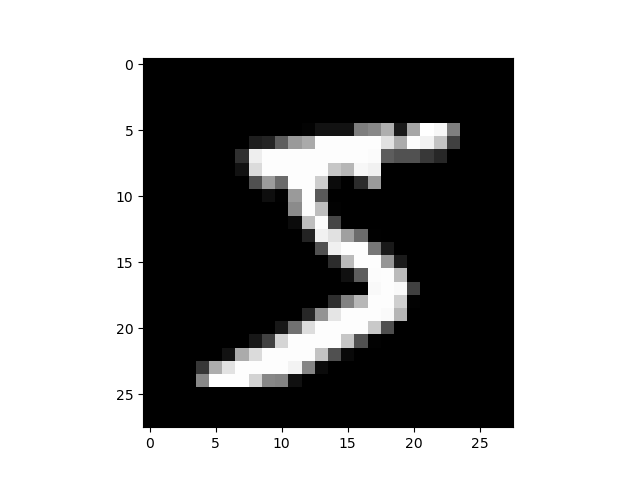

In [5]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [6]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

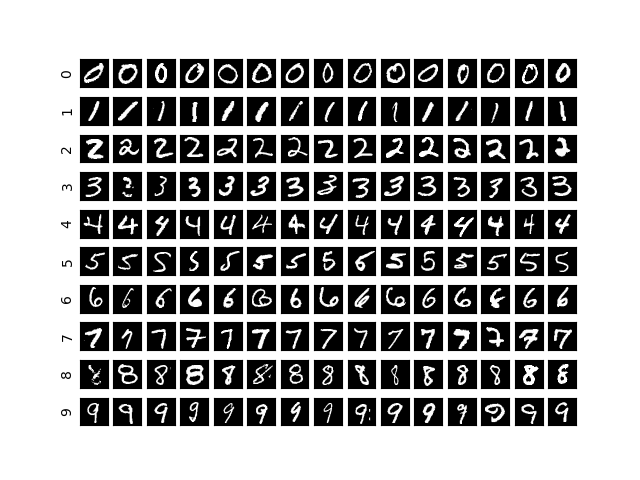

In [7]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

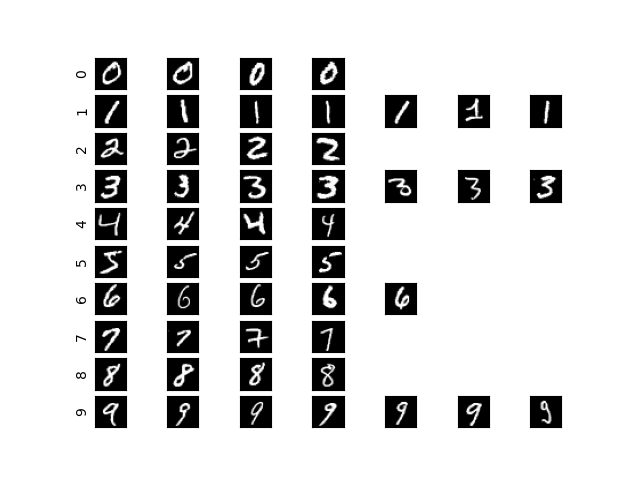

In [8]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [9]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

### 1. Training
Complete the `nb_train` function. (1 Point)

In [ ]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = np.zeros(C)
    # YOUR CODE HERE

    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K))
    # YOUR CODE HERE

    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [ ]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

In [ ]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

### 2. Prediction
Complete the `nb_predict` function. (1 Point)

In [ ]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [ ]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    # YOUR CODE HERE

    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")
    # YOUR CODE HERE

    return dict(yhat=yhat, logprob=logprob)

In [ ]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

### 3. Experiments on MNIST Digits Data
No changes necessary in this section.

In [ ]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, X_test)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [ ]:
# Accuracy
sklearn.metrics.accuracy_score(y_test, yhat)

In [ ]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(X_test, yhat)
plt.suptitle("Digits grouped by predicted label")

In [ ]:
# do the same, but this time show wrong predicitions only
perror = y_test != yhat
nextplot()
showdigits(X_test[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

In [ ]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(X_test[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [ ]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(y_test, yhat))
print(sklearn.metrics.confusion_matrix(y_test, yhat))  # true x predicted

In [ ]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(y_test, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

In [ ]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(y_test[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

In [ ]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(y_test[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

### 4. Model Selection
Complete the code to use cross-validation to find a good value of alpha. (1 Point)

In [ ]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

In [ ]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.

### 5. Generating Data
Complete the `nb_generate` function to generate new digit images from the learned model. (1 Point)

In [ ]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        # YOUR CODE HERE

    return Xgen

In [ ]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

In [ ]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

In [ ]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")